In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import glob
import os
import math
import itertools
import glob
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from shapely.geometry import Point, LineString

## NSW Beach Profile Database
To do: resolve issues with 0 elevation 0 distance LiDAR values

In [282]:
sites = ['Tweed Entrance']

for site in sites:

    # Read in data
    profiles_df = pd.read_csv(f'validation/raw_data/NSW_BeachProfileDatabase/photogrammetry_Xsections_{site}.csv', skiprows=5, parse_dates=True)
    profiles_df = profiles_df[profiles_df['Year/Date'] > '1987']

    # Add ID column
    profiles_df['site'] = profiles_df['Beach'].map(str) + '_' + profiles_df['Block'].map(str) + '_' + profiles_df['Profile'].map(str)

    # # Rename columns
    profiles_df.rename({'Year/Date': 'date', 'Survey Type': 'source', 'Beach': 'beach', 'Block': 'section', 'Profile': 'profile'}, axis=1, inplace=True)

    # Compute origin and end points for each profile
    origin_xy = profiles_df.loc[profiles_df.groupby(['site']).Chainage.idxmin(), ['site', 'Easting', 'Northing']]
    end_xy = profiles_df.loc[profiles_df.groupby(['site']).Chainage.idxmax(), ['site', 'Easting', 'Northing']]
    origin_xy.rename({'Easting': 'origin_x', 'Northing': 'origin_y'}, inplace=True, axis=1)
    end_xy.rename({'Easting': 'end_x', 'Northing': 'end_y'}, inplace=True, axis=1)
    end_xy.reset_index(drop=True, inplace=True)
    origin_xy.reset_index(drop=True, inplace=True)

    # Join origin and end points into dataframe
    profiles_df = pd.merge(left=profiles_df, right=origin_xy)
    profiles_df = pd.merge(left=profiles_df, right=end_xy)
    
#     # Restrict all profiles to foredune: area seaward of highest elevation
#     profiles_df = (profiles_df
#                    .groupby(['site', 'date'], as_index=False)
#                    .apply(lambda x: x[x['Chainage'] > x.loc[x.Elevation.idxmax(), 'Chainage']])
#                    .reset_index(drop=True))
    
    # Identify distance and coordinates of foredune and add to dataframe
    foredune = profiles_df.loc[profiles_df.groupby(['site', 'date']).Chainage.idxmin(), ['site', 'date', 'Easting', 'Northing', 'Chainage']]
    foredune.rename({'Chainage': 'foredune_dist', 'Easting': 'foredune_x', 'Northing': 'foredune_y'}, inplace=True, axis=1)
    profiles_df = pd.merge(left=profiles_df, right=foredune)

    # Find location and distance to water / X AHD
    profiles_interp = []

    for i in [0.0, 0.5, 1.0]:        

#         out = profiles_df.groupby(['site', 'date']).apply(lambda x: pd.Series({f'ahd{i}_dist': interp1d(x.Elevation, x.Chainage)(i),
#                                                                                f'ahd{i}_x': interp1d(x.Elevation, x.Easting)(i),
#                                                                                f'ahd{i}_y': interp1d(x.Elevation, x.Northing)(i)})

        out = profiles_df.groupby(['site', 'date']).apply(lambda x: pd.Series({f'ahd{i}_dist': interp_intercept(x.Chainage.values,x.Elevation.values, i, True),
                                                                               f'ahd{i}_x': interp_intercept(x.Easting.values,x.Elevation.values, i, True),
                                                                               f'ahd{i}_y': interp_intercept(x.Northing.values,x.Elevation.values, i, True)})                                             
                                                          
                                                          
                                                          
                                                          if (x.Elevation.min() < i) & (x.Elevation.max() > i) 

                                                          else pd.Series({f'ahd{i}_dist': np.nan,
                                                                          f'ahd{i}_x': np.nan,
                                                                          f'ahd{i}_y': np.nan}))

        profiles_interp.append(out.astype(np.float64))

    # Join values back into dataframe
    shoreline_dist = profiles_df.groupby(['site', 'date']).first().join(profiles_interp)
    shoreline_dist.drop(['Chainage', 'Elevation', 'Easting', 'Northing'], axis=1, inplace=True)
    shoreline_dist.reset_index(inplace=True)

    # Fix datetime
    shoreline_dist['date'] = pd.to_datetime(shoreline_dist.date)

    # Enforce column order
    shoreline_dist = shoreline_dist[['site', 'beach', 'section', 'profile', 'date', 'source', 'origin_x', 'origin_y', 'end_x', 'end_y', 
                                     'foredune_dist', 'foredune_x', 'foredune_y',
                      'ahd0.0_dist', 'ahd0.0_x', 'ahd0.0_y', 'ahd0.5_dist', 'ahd0.5_x', 'ahd0.5_y', 'ahd1.0_dist', 'ahd1.0_x', 'ahd1.0_y']]

    # Write to file
    shoreline_dist.to_csv(f'validation/processed/validation_{site}.csv', index=False)

shoreline_dist.head()

,site,beach,section,profile,date,source,origin_x,origin_y,end_x,end_y,...,foredune_y,ahd0.0_dist,ahd0.0_x,ahd0.0_y,ahd0.5_dist,ahd0.5_x,ahd0.5_y,ahd1.0_dist,ahd1.0_x,ahd1.0_y
0,Tweed Entrance_1_1,Tweed Entrance,1,1,1999-09-05,Stereo photogrammtery,555745.19,6880467.95,555999.5,6880658.53,...,6880467.95,NaN,NaN,NaN,242.466870,555939.148742,6.880613e+06,236.124166,555934.075114,6.880609e+06
1,Tweed Entrance_1_1,Tweed Entrance,1,1,2004-07-14,Stereo photogrammtery,555745.19,6880467.95,555999.5,6880658.53,...,6880467.54,280.634957,555969.091341,6.880636e+06,253.246801,555947.175166,6.880619e+06,242.363595,555938.466726,6.880613e+06
2,Tweed Entrance_1_1,Tweed Entrance,1,1,2007-03-12,Stereo photogrammtery,555745.19,6880467.95,555999.5,6880658.53,...,6880467.94,263.438740,555955.913965,6.880626e+06,254.390919,555948.677282,6.880620e+06,245.343098,555941.440599,6.880615e+06
3,Tweed Entrance_1_1,Tweed Entrance,1,1,2010-01-26,Stereo photogrammtery,555745.19,6880467.95,555999.5,6880658.53,...,6880467.94,251.715916,555946.521221,6.880619e+06,236.585948,555934.416453,6.880610e+06,232.796875,555931.386897,6.880607e+06
4,Tweed Entrance_1_1,Tweed Entrance,1,1,2014-09-16,Stereo photogrammtery,555745.19,6880467.95,555999.5,6880658.53,...,6880467.94,NaN,NaN,NaN,315.500556,555997.637778,6.880657e+06,244.918545,555941.154545,6.880615e+06


In [103]:
# profiles_df.groupby(/['site', 'date']).apply(lambda x: pd.Series({'foredune': x.loc[x.Elevation.idxmax(), 'Chainage']})).loc['Avoca_5_6']

# profiles_df.groupby(['site', 'date']).filter(lambda x: x['Chainage'].mean() > x.loc[x.Elevation.idxmax(), 'Chainage'])
# x = profiles_df[(profiles_df.section == 5) & (profiles_df.profile == 6) &  (profiles_df.date == '2016-06-07')]  



# groups.apply(lambda g: g[g['B'] == g['B'].max()])
# out = x.loc[x.Elevation.idxmax(), 'Chainage']


# df.groupby('c')['type'].transform('size')

    
# Restrict all profiles to foredune: area seaward of highest elevation
# profiles_df.groupby(['site', 'date']).transform(func = lambda x: x.loc[x.Elevation.idxmax(), 'Chainage'], axis=1)



In [269]:
# profiles_df.date.unique()

# shoreline_dist[shoreline_dist.site == 'Tweed Entrance_5_5']

,site,beach,section,profile,date,source,origin_x,origin_y,end_x,end_y,...,foredune_y,ahd0.0_dist,ahd0.0_x,ahd0.0_y,ahd0.5_dist,ahd0.5_x,ahd0.5_y,ahd1.0_dist,ahd1.0_x,ahd1.0_y
102,Tweed Entrance_5_5,Tweed Entrance,5,5,1999-09-05,Stereo photogrammtery,554234.08,6883670.84,554634.11,6883770.27,...,6883681.83,345.061063,554568.881472,6.883754e+06,333.241026,554557.412647,6.883751e+06,326.421245,554550.795000,6.883749e+06
103,Tweed Entrance_5_5,Tweed Entrance,5,5,2004-07-14,Stereo photogrammtery,554234.08,6883670.84,554634.11,6883770.27,...,6883693.25,NaN,NaN,NaN,260.048785,554486.569522,6.883733e+06,248.435019,554475.298191,6.883731e+06
104,Tweed Entrance_5_5,Tweed Entrance,5,5,2007-03-12,Stereo photogrammtery,554234.08,6883670.84,554634.11,6883770.27,...,6883695.48,NaN,NaN,NaN,239.614889,554466.607015,6.883728e+06,235.818593,554462.923391,6.883728e+06
105,Tweed Entrance_5_5,Tweed Entrance,5,5,2010-01-26,Stereo photogrammtery,554234.08,6883670.84,554634.11,6883770.27,...,6883679.17,258.964700,554485.380040,6.883733e+06,253.851999,554480.420201,6.883732e+06,248.739298,554475.460361,6.883731e+06
106,Tweed Entrance_5_5,Tweed Entrance,5,5,2014-09-16,Stereo photogrammtery,554234.08,6883670.84,554634.11,6883770.27,...,6883674.10,394.576000,554617.040000,6.883766e+06,277.873000,554503.765000,6.883738e+06,249.997111,554476.708889,6.883731e+06
107,Tweed Entrance_5_5,Tweed Entrance,5,5,2016-08-01,LiDar,554234.08,6883670.84,554634.11,6883770.27,...,6883709.22,270.848484,554496.946774,6.883736e+06,254.589657,554481.164000,6.883732e+06,243.046000,554469.964000,6.883730e+06


,beach,section,profile,date,Chainage,Elevation,Easting,Northing,source,site,origin_x,origin_y,end_x,end_y,foredune_x,foredune_y,foredune_dist
13713,Tweed Entrance,5,5,2014-09-16,12.408,5.675,554246.10,6883674.10,Stereo photogrammtery,Tweed Entrance_5_5,554234.08,6883670.84,554634.11,6883770.27,554246.1,6883674.1,12.408
13714,Tweed Entrance,5,5,2014-09-16,12.823,5.629,554246.50,6883674.20,Stereo photogrammtery,Tweed Entrance_5_5,554234.08,6883670.84,554634.11,6883770.27,554246.1,6883674.1,12.408
13715,Tweed Entrance,5,5,2014-09-16,13.779,5.512,554247.43,6883674.43,Stereo photogrammtery,Tweed Entrance_5_5,554234.08,6883670.84,554634.11,6883770.27,554246.1,6883674.1,12.408
13716,Tweed Entrance,5,5,2014-09-16,13.853,5.503,554247.50,6883674.45,Stereo photogrammtery,Tweed Entrance_5_5,554234.08,6883670.84,554634.11,6883770.27,554246.1,6883674.1,12.408
13717,Tweed Entrance,5,5,2014-09-16,14.078,5.476,554247.72,6883674.50,Stereo photogrammtery,Tweed Entrance_5_5,554234.08,6883670.84,554634.11,6883770.27,554246.1,6883674.1,12.408
13718,Tweed Entrance,5,5,2014-09-16,14.883,5.387,554248.50,6883674.69,Stereo photogrammtery,Tweed Entrance_5_5,554234.08,6883670.84,554634.11,6883770.27,554246.1,6883674.1,12.408
13719,Tweed Entrance,5,5,2014-09-16,15.148,5.363,554248.76,6883674.76,Stereo photogrammtery,Tweed Entrance_5_5,554234.08,6883670.84,554634.11,6883770.27,554246.1,6883674.1,12.408
13720,Tweed Entrance,5,5,2014-09-16,15.913,5.285,554249.50,6883674.94,Stereo photogrammtery,Tweed Entrance_5_5,554234.08,6883670.84,554634.11,6883770.27,554246.1,6883674.1,12.408
13721,Tweed Entrance,5,5,2014-09-16,16.518,5.241,554250.09,6883675.09,Stereo photogrammtery,Tweed Entrance_5_5,554234.08,6883670.84,554634.11,6883770.27,554246.1,6883674.1,12.408
13722,Tweed Entrance,5,5,2014-09-16,16.944,5.206,554250.50,6883675.19,Stereo photogrammtery,Tweed Entrance_5_5,554234.08,6883670.84,554634.11,6883770.27,554246.1,6883674.1,12.408


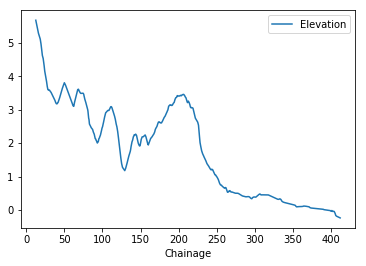

In [270]:
test = profiles_df[(profiles_df.site == 'Tweed Entrance_5_5') & (profiles_df.date == '2014-09-16')]  
test.plot(x='Chainage', y='Elevation')
test 
# test.loc[test.groupby(['site']).Elevation.idxmax(), ['site', 'Easting', 'Northing', 'Chainage', 'ahd0.0_dist']]

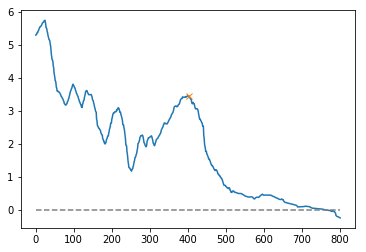

In [339]:
test = profiles_df[(profiles_df.site == 'Tweed Entrance_5_5') & (profiles_df.date == '2014-09-16')]  

import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
x = test.Elevation.values # electrocardiogram()[2000:4000]
peaks, _ = find_peaks(x, prominence=2)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
x = test.Elevation.values # electrocardiogram()[2000:4000]
peaks, _ = find_peaks(x,prominence=2)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [272]:
x

array([-0.9  , -0.895, -0.895, ..., -0.67 , -0.65 , -0.615])

In [199]:
test = profiles_df[(profiles_df.site == 'Avoca_5_1') & (profiles_df.date == '2008-07-03')] 
interp1d(test.sort_values('Chainage').Elevation, test.sort_values('Chainage').Chainage, assume_sorted=False)(0)

array(133.81565065)

In [211]:
xp = [1, 2, 3]
fp = [3, 2, 0]
np.interp(2.5, test.Elevation, test.Chainage)

201.03900000000002

In [262]:
from __future__ import division 
import numpy as np
import matplotlib.pyplot as plt

def interp_intercept(x, y1, y2, reverse=False):
    """Find the intercept of two curves, given by the same x data"""
    
    def intercept(point1, point2, point3, point4):
        """find the intersection between two lines
        the first line is defined by the line between point1 and point2
        the first line is defined by the line between point3 and point4
        each point is an (x,y) tuple.

        So, for example, you can find the intersection between
        intercept((0,0), (1,1), (0,1), (1,0)) = (0.5, 0.5)

        Returns: the intercept, in (x,y) format
        """    

        def line(p1, p2):
            A = (p1[1] - p2[1])
            B = (p2[0] - p1[0])
            C = (p1[0]*p2[1] - p2[0]*p1[1])
            return A, B, -C

        def intersection(L1, L2):
            D  = L1[0] * L2[1] - L1[1] * L2[0]
            Dx = L1[2] * L2[1] - L1[1] * L2[2]
            Dy = L1[0] * L2[2] - L1[2] * L2[0]

            x = Dx / D
            y = Dy / D
            return x,y

        L1 = line([point1[0],point1[1]], [point2[0],point2[1]])
        L2 = line([point3[0],point3[1]], [point4[0],point4[1]])

        R = intersection(L1, L2)

        return R

    try:
        
        if isinstance(y2, (int, float)):

            y2 = np.array([y2] * len(x))

        if reverse:

            x = x[::-1]
            y1 = y1[::-1]
            y2 = y2[::-1]

        idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)
        xc, yc = intercept((x[idx], y1[idx]),((x[idx+1], y1[idx+1])), ((x[idx], y2[idx])), ((x[idx+1], y2[idx+1])))

        return xc[0][0]
    
    except: 
        
        return np.nan

x  = test.Chainage.values
y1 = test.Elevation.values
y2 = 0.5 

# new method!
interp_intercept(x, y1, y2, reverse=False)

37.664562264150945

array([1, 1, 1, 1, 1, 1, 1])

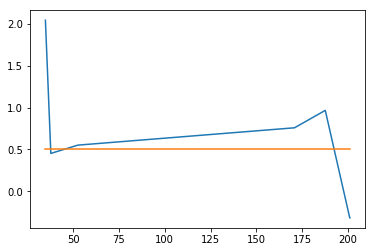

In [256]:
if isinstance(y2, (int, float)):

    y2 = np.array([y2] * len(x))
    
plt.plot(x, y1)
plt.plot(x, y2)

In [260]:
profiles_df.groupby(['site', 'date']).apply(lambda x: pd.Series({f'ahd{i}_dist': interpolated_intercept(x.Chainage.values,x.Elevation.values, 0.5)}))

ahd1.0_dist
site      date                   
Avoca_1_1 1990-05-04   117.200176
          1993-04-20   126.784578
          1996-06-30   117.109692
          2001-09-13   121.529271
          2006-03-06   128.471081
          2008-07-03   121.137811
          2016-06-07          NaN
Avoca_1_2 1990-05-04   111.082362
          1993-04-20   111.122431
          1996-06-30   107.809353
          2001-09-13   117.267935
          2006-03-06   122.966373
          2008-07-03   114.092133
          2016-06-07   117.085200
Avoca_1_3 1990-05-04   109.544688
          1993-04-20   111.138795
          1996-06-30   103.780267
          2001-09-13   108.150910
          2006-03-06   115.401999
          2008-07-03   105.247773
          2016-06-07   112.439000
Avoca_1_4 1990-05-04   106.233182
          1993-04-20   109.336764
          1996-06-30   108.948040
          2001-09-13   102.663086
          2006-03-06   113.685946
          2008-07-03   114.574058
          2016-06-07   110.540102
Avoca_1_5 1990-05-04   108.764700
          1993-04-20   109.713133
...                           ...
Avoca_9_4 2008-07-03   125.136075
          2016-06-07          NaN
Avoca_9_5 1990-05-04   124.515721
          1993-04-20   145.602174
          1996-06-30   129.116827
          2001-09-13   129.256165
          2006-03-06   120.033129
          2008-07-03   143.315460
          2016-06-07   129.034080
Avoca_9_6 1990-05-04   147.482160
          1993-04-20          NaN
          1996-06-30   137.929646
          2001-09-13   151.247534
          2006-03-06   140.294027
          2008-07-03          NaN
          2016-06-07   135.195370
Avoca_9_7 1990-05-04          NaN
          1993-04-20          NaN
          1996-06-30   155.193900
          2001-09-13          NaN
          2006-03-06          NaN
          2008-07-03          NaN
          2016-06-07          NaN
Avoca_9_8 1990-05-04          NaN
          1993-04-20          NaN
          1996-06-30          NaN
          2001-09-13          NaN
          2006-03-06          NaN
          2008-07-03          NaN
          2016-06-07          NaN

[606 rows x 1 columns]

In [227]:
np.array([5., 5., 0., 0., 0., 0., 0.])

array([0., 0., 0., 0., 0., 0., 0.])

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: 'site' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  app.launch_new_instance()


,,,site,Easting,Northing,Chainage
site,date,,,,,
Avoca_7_5,1990-05-04,32805,Avoca_7_5,354811.94,6296594.73,61.08


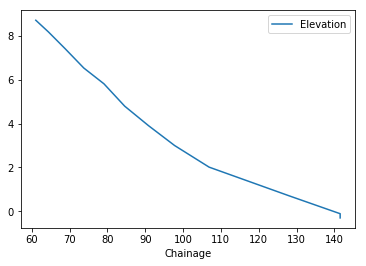

In [69]:
test = profiles_df[(profiles_df.section == 7) & (profiles_df.profile == 5) &  (profiles_df.date == '1990-05-04')]
test.plot(x='Chainage', y='Elevation')
test.loc[test.groupby(['site']).Elevation.idxmax(), ['site', 'Easting', 'Northing', 'Chainage']]

## Gold Coast

In [2]:
# List of sites to iterate over
sites = ['BILINGA',
#          'BROADBEACH',
#          'BURLEIGH HEADS',
#          'COOLANGATTA',
#          'CURRUMBIN',
         'DURANBAH',
         'FINGAL',
         'GREENMOUNT HILL',
         'KINGSCLIFF',
         'KIRRA',
         'KIRRA RADIALS',
         'MAIN BEACH',
         'MERMAID BEACH',
         'MIAMI',
         'Main Beach Cross Sections',
         'NARROWNECK',
         'NORTH KIRRA',
         'NOTH KIRRA',
         'PALM BEACH',
         'POINT DANGER',
         'RAINBOW BAY',
         'SEAWAY CENTRE LINE',
         'SNAPPER ROCKS',
         'SOUTH STRADBROKE',
         'SURFERS PARADISE',
         'THE SPIT',
         'TUGUN',
         'TWEED RIVER ENTRANCE']

# sites = ['NARROWNECK']

# Dictionary to manually rename problematic surveys
manual_rename = {'BILINGA K37A': 'BILINGA', 'CURRUMBIN (27A)': 'CURRUMBIN', 'NORTH KIRRA (confirmed)':'NORTH KIRRA', 
                 'PALM BEACH (28A)':'PALM BEACH', 'PALM BEACH (30A)':'PALM BEACH', 'PALM BEACH (31A)':'PALM BEACH', 
                 'SURFERS PARADISE (no longer used)': 'SURFERS PARADISE'}

failed_list = []

for site in sites:
    
    print(site)
    
    ##################################
    # Extract profiles for each site #
    ##################################   
    
    # List of profile datasets to iterate through
    profile_list = glob.glob(f'validation/raw_data/CityofGoldCoast/ETA Lines- 20181213/{site}*.txt')
    
    # Output list to hold data
    site_profiles = []

    for profile_i in profile_list:

        try:

            # Identify unique field values from file string
            profile_string = os.path.basename(profile_i)

            # Treat data file string differently depending on format
            if len(profile_string.split(' - ')) > 3:

                beach, section, profile, id_date = profile_string.split(' - ')            

            else:

                beach, section_profile, id_date = profile_string.split(' - ')
                section, profile = section_profile.split(' ')
            
            # If beach name is in the list of problematic names, replace
            if beach in manual_rename.keys():      
                beach = manual_rename[beach]
            
            # Remove any special characters from beach/section/profile names and create ID 
            beach = beach.replace(' ', '') 
            name = (beach + '_' + section + '_' + profile).replace('\xa0', '').replace(' ', '')    
            date = id_date[-14:-4]

            # Import data and add in fields
            profile_df = pd.read_csv(profile_i, delim_whitespace=True, names=['point_id', 'x', 'y', 'z'])
            profile_df['date'] = date
            profile_df['site'] = name        
            profile_df['profile'] = profile  
            profile_df['section'] = section 
            profile_df['beach'] = beach 

            site_profiles.append(profile_df)

        except:

            failed_list.append(profile_i)            

    try:
        
        # Combine into a single dataframe, and drop pre-1987 and deep water samples
        profiles_df = pd.concat(site_profiles)
        profiles_df = profiles_df[profiles_df.z > -3.0]
        profiles_df = profiles_df[profiles_df.date > '1987']
        profiles_df.drop('point_id', axis=1, inplace=True)

        # Compute origin and end points for each profile
        origin_xy = profiles_df.groupby(['site']).first().reset_index()[['site', 'x', 'y']]
        end_xy = profiles_df.groupby(['site']).last().reset_index()[['site', 'x', 'y']]
        origin_xy.rename({'x': 'origin_x', 'y': 'origin_y'}, inplace=True, axis=1)
        end_xy.rename({'x': 'end_x', 'y': 'end_y'}, inplace=True, axis=1)
        end_xy.reset_index(drop=True, inplace=True)
        origin_xy.reset_index(drop=True, inplace=True)

        # Join origin and end points into dataframe
        profiles_df = pd.merge(left=profiles_df, right=origin_xy)
        profiles_df = pd.merge(left=profiles_df, right=end_xy)

        # Compute chainage
        profiles_df['Chainage'] = profiles_df.apply(lambda x: math.hypot(x.x - x.origin_x, x.y - x.origin_y), axis = 1)

        # Find location and distance to water / X AHD
        profiles_interp = []

        for i in [0.0, 0.5, 1.0]:

            out = profiles_df.groupby(['site', 'date']).apply(lambda x: pd.Series({f'ahd{i}_dist': interp1d(x.z, x.Chainage)(i),
                                                                                   f'ahd{i}_x': interp1d(x.z, x.x)(i),
                                                                                   f'ahd{i}_y': interp1d(x.z, x.y)(i)})

                                                              if (x.z.min() < i) & (x.z.max() > i) 

                                                              else pd.Series({f'ahd{i}_dist': np.nan,
                                                                              f'ahd{i}_x': np.nan,
                                                                              f'ahd{i}_y': np.nan}))

            profiles_interp.append(out.astype(np.float64))

        # Join values back into dataframe
        shoreline_dist = profiles_df.groupby(['site', 'date']).first().join(profiles_interp)
        shoreline_dist.drop(['Chainage', 'z', 'x', 'y'], axis=1, inplace=True)
        shoreline_dist.reset_index(inplace=True)

        # Fix datetime
        shoreline_dist['date'] = pd.to_datetime(shoreline_dist.date)

        # Insert annotation column
        shoreline_dist.insert(2, 'source', 'CityofGoldCoast')

        # Enforce column order
        shoreline_dist = shoreline_dist[['site', 'beach', 'section', 'profile', 'date', 'source', 
                                         'origin_x', 'origin_y', 'end_x', 'end_y', 
                                         'ahd0.0_dist', 'ahd0.0_x', 'ahd0.0_y', 
                                         'ahd0.5_dist', 'ahd0.5_x', 'ahd0.5_y', 
                                         'ahd1.0_dist', 'ahd1.0_x', 'ahd1.0_y']]

        # Write to file
        shoreline_dist.to_csv(f'validation/processed/validation_{beach}.csv', index=False)
        shoreline_dist.head()
        
    except: 
        print(f'Skipping {site}'

DURANBAH
FINGAL
GREENMOUNT HILL
KINGSCLIFF
KIRRA
KIRRA RADIALS
Skipping KIRRA RADIALS
MAIN BEACH
MERMAID BEACH
MIAMI
Main Beach Cross Sections
Skipping Main Beach Cross Sections
NARROWNECK
NORTH KIRRA
NOTH KIRRA
PALM BEACH
POINT DANGER
RAINBOW BAY
SEAWAY CENTRE LINE
Skipping SEAWAY CENTRE LINE
SNAPPER ROCKS
SOUTH STRADBROKE
SURFERS PARADISE
THE SPIT
TUGUN
TWEED RIVER ENTRANCE


In [ ]:
pd.concat(site_profiles)

## Narrabeen

In [ ]:
import re
from pyproj import Proj, transform
from shapely.geometry import Point, LineString
import geopandas as gpd
import pandas as pd
import numpy as np

def dms2dd(s):
    # example: s = "0°51'56.29"
    degrees, minutes, seconds = re.split('[°\'"]+', s)
    if float(degrees) > 0:
        dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    else:
        dd = float(degrees) - float(minutes)/60 - float(seconds)/(60*60);
    return dd

def dist_angle(lon, lat, dist, angle):
    lon_2 = lon + dist *  np.sin(angle * np.pi / 180)
    lat_2 = lat + dist *  np.cos(angle * np.pi / 180)
    return pd.Series({'y2': lat_2, 'x2': lon_2})


# Import data and parse DMS to DD
data = "PF1 -33°42'20.65 151°18'16.30 118.42\nPF2 -33°42'33.45 151°18'10.33 113.36\nPF4 -33°43'01.55 151°17'58.84 100.26\nPF6 -33°43'29.81 151°17'58.65 83.65\nPF8 -33°43'55.94 151°18'06.47 60.48"
coords = pd.read_csv(pd.compat.StringIO(data), sep=' ', names=['profile', 'y', 'x', 'angle'])
coords['x'] = [dms2dd(i) for i in coords.x]
coords['y'] = [dms2dd(i) for i in coords.y]
coords

# Extend survey lines out from start coordinates using supplied angle
coords_end = coords.apply(lambda x: dist_angle(x.x, x.y, 0.005, x.angle), axis = 1)
coords = pd.concat([coords, coords_end], axis=1).drop('angle', axis=1)

# Rename fields
coords = coords.rename({'y': 'origin_y', 'x': 'origin_x', 'y2': 'end_y', 'x2': 'end_x'}, axis=1)

# Reproject coords to Albers and create geodataframe
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:32756')
coords['origin_x'], coords['origin_y'] = transform(inProj,outProj,coords.origin_x.values,coords.origin_y.values)
coords['end_x'], coords['end_y'] = transform(inProj,outProj,coords.end_x.values,coords.end_y.values)
# coords['geometry'] = coords.apply(lambda x: LineString([Point(x.x, x.y), Point(x.x2, x.y2)]), axis = 1)
# transects_gdf = gpd.GeoDataFrame(coords, geometry='geometry').set_index('site')
# transects_gdf.crs = 'EPSG:32756'

# Add ID column
coords['site'] = 'Narrabeen_all_' + coords['profile'].map(str)
coords['beach'] = 'Narrabeen'
coords['section'] = 'all'
coords['source'] = 'Beach profile'
coords

# shoreline_dist = shoreline_dist[['site', 'beach', 'section', 'profile', 'date', 'source', 'origin_x', 'origin_y', 'end_x', 'end_y', 
#                       'ahd0.0_dist', 'ahd0.0_x', 'ahd0.0_y', 'ahd0.5_dist', 'ahd0.5_x', 'ahd0.5_y', 'ahd1.0_dist', 'ahd1.0_x', 'ahd1.0_y']]

In [ ]:
##############
# Validation #
##############

profiles_df = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/validation/raw_data/WRL/Narrabeen/Narrabeen_Profiles.csv', 
                          skiprows=1, names=['profile', 'date', 'distance', 'elevation', 'flag'])

# Set to datetime
profiles_df['date'] = pd.to_datetime(profiles_df['date'], format='%d/%m/%Y')

# Restrict to years
profiles_df = profiles_df[(profiles_df.date.dt.year > 1987) & (profiles_df.date.dt.year < 2016)]

# Add site column
profiles_df = profiles_df.merge(coords, on='profile')


# Find location and distance to water / X AHD
profiles_interp = []

for i in [0.0, 0.5, 1.0]:

    out = profiles_df.groupby(['site', 'date']).apply(lambda x: pd.Series({f'ahd{i}_dist': interp1d(x.elevation, x.distance)(i)})

                                                      if (x.elevation.min() < i) & (x.elevation.max() > i) 

                                                      else pd.Series({f'ahd{i}_dist': np.nan}))

    profiles_interp.append(out.astype(np.float64))

# Join values back into dataframe
shoreline_dist = profiles_df.groupby(['site', 'date']).first().join(profiles_interp)
shoreline_dist.drop(['distance', 'elevation'], axis=1, inplace=True)
shoreline_dist.reset_index(inplace=True)

# Enforce column order
shoreline_dist = shoreline_dist[['site', 'beach', 'section', 'profile', 'date', 'source', 
                                 'origin_x', 'origin_y', 'end_x', 'end_y', 
                                 'ahd0.0_dist', 'ahd0.5_dist', 'ahd1.0_dist']]

# Write to file
shoreline_dist.to_csv(f'validation/processed/validation_Narrabeen.csv', index=False)
shoreline_dist.head()

# # Use linear interpolation to find distance along beach of 0 elevation 
# from scipy.interpolate import interp1d
# profiles_interp = profiles_df.groupby(['site', 'date']).apply(lambda x: interp1d(x.elevation, x.distance)(0.5) if 
#                                                                 x.elevation.min() < 0 else np.nan)  #.plot()

# profiles_interp = profiles_interp.loc[transect_id].astype(np.float)
# profiles_interp.to_frame()
# validation_beachwidths = profiles_interp.groupby(profiles_interp.index.year).mean()
# validation_beachwidths_std = profiles_interp.groupby(profiles_interp.index.year).std()
# validation_beachwidths = validation_beachwidths.rename('Validation beach width (m)')
# validation_beachwidths_std = validation_beachwidths_std.rename('Validation beach width (stdev)')

In [ ]:
shoreline_dist

In [ ]:
shoreline_dist